# Visualizing training behavior

In [2]:
using JLD2, LinearAlgebra
using CairoMakie
using MyTwoLayerNN

include("../experimentplots.jl")

createorientiationplot (generic function with 1 method)

Create the NN

In [2]:
# Data parameters
d = 1
dataX = [[-1/2], [-1/6], [1/6], [1/2]]
dataY = [1/4, 1/30, 1/30, 1/4]
# dataY = [1/4, 1/30, 1/30, 2/30 - 1/4]

# NN parameters
m = 1_000
γ = 1.5    # w-lag (1.5, 0.25) lr=10, a-lag (1.5, -0.5) lr=1000
γ′ = -0.5

nn = TwoLayerNN(d, m, γ, γ′)

# Create copy of inital weights 
initialNN = copy(nn)

# Training parameters
learning_rate = 1000.0
max_steps = 100_000_000

training_data = TrainingData(dataX, dataY, learning_rate, max_steps)

TrainingData{Float64, Int64}([[-0.5], [-0.16666666666666666], [0.16666666666666666], [0.5]], [0.25, 0.03333333333333333, 0.03333333333333333, 0.25], 1000.0, 100000000)

Create callback function

In [3]:
w_norms = [norm(nn.w)]
b_norms = [norm(nn.b)]
a_norms = [norm(nn.a)]
ab_norms = [norm(nn.a .* nn.b)]
wb_norms = [norm(nn.w .* nn.b)]

function mycallback(nn, step, loss; ∇=nothing)
    if step % 1000 == 0
        push!(w_norms, norm(nn.w))
        push!(b_norms, norm(nn.b))
        push!(a_norms, norm(nn.a))
        push!(ab_norms, norm(nn.a .* nn.b))
        push!(wb_norms, norm(nn.w .* nn.b))
    end
end

mycallback (generic function with 1 method)

Train the network

In [5]:
train!(nn, training_data; callback2=mycallback)

Number of steps: 652133


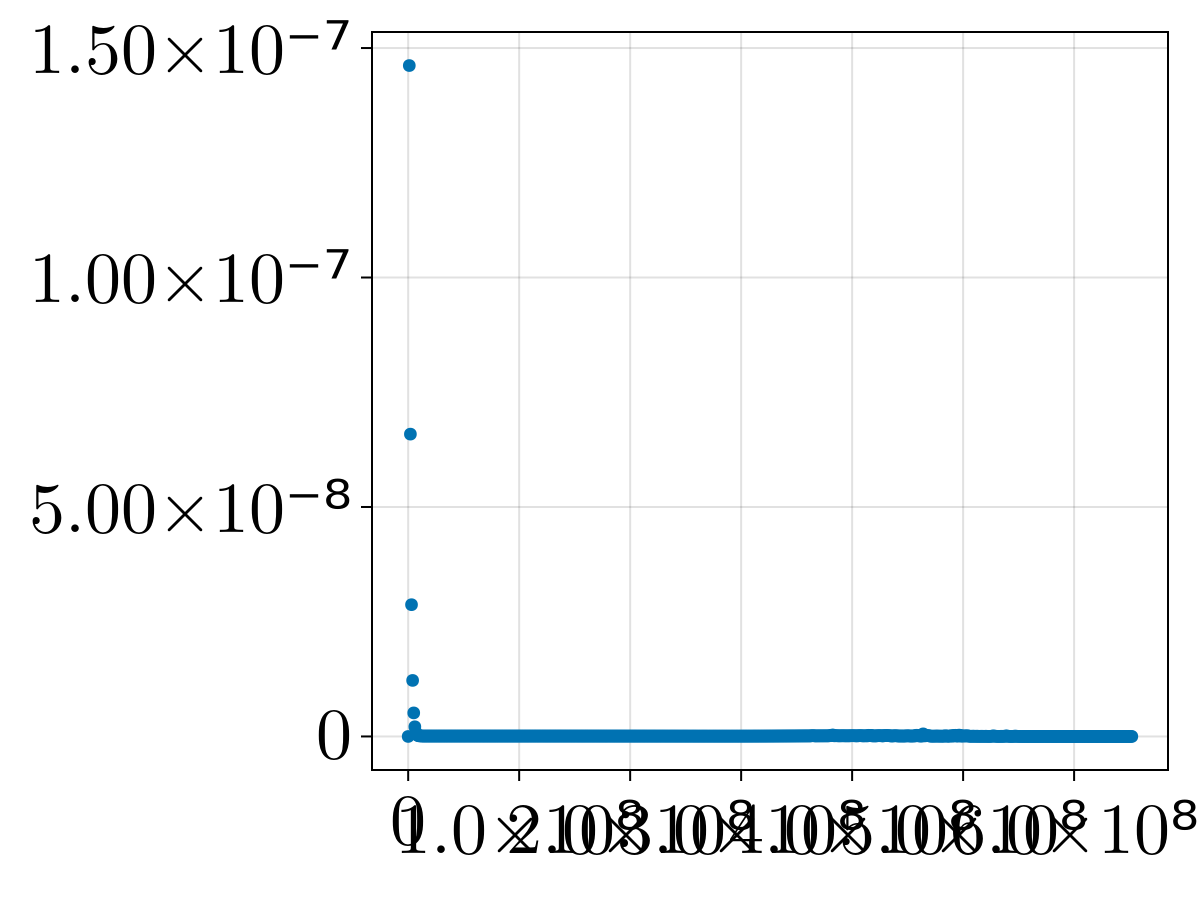

In [7]:
f = Figure()
ax = Axis(f[1, 1])

steps = 1000 * (0:1:(length(ab_norms) - 1)) * learning_rate

scat = scatter!(ax, steps, wb_norms)

f

Visualize size of w and a parameters during training

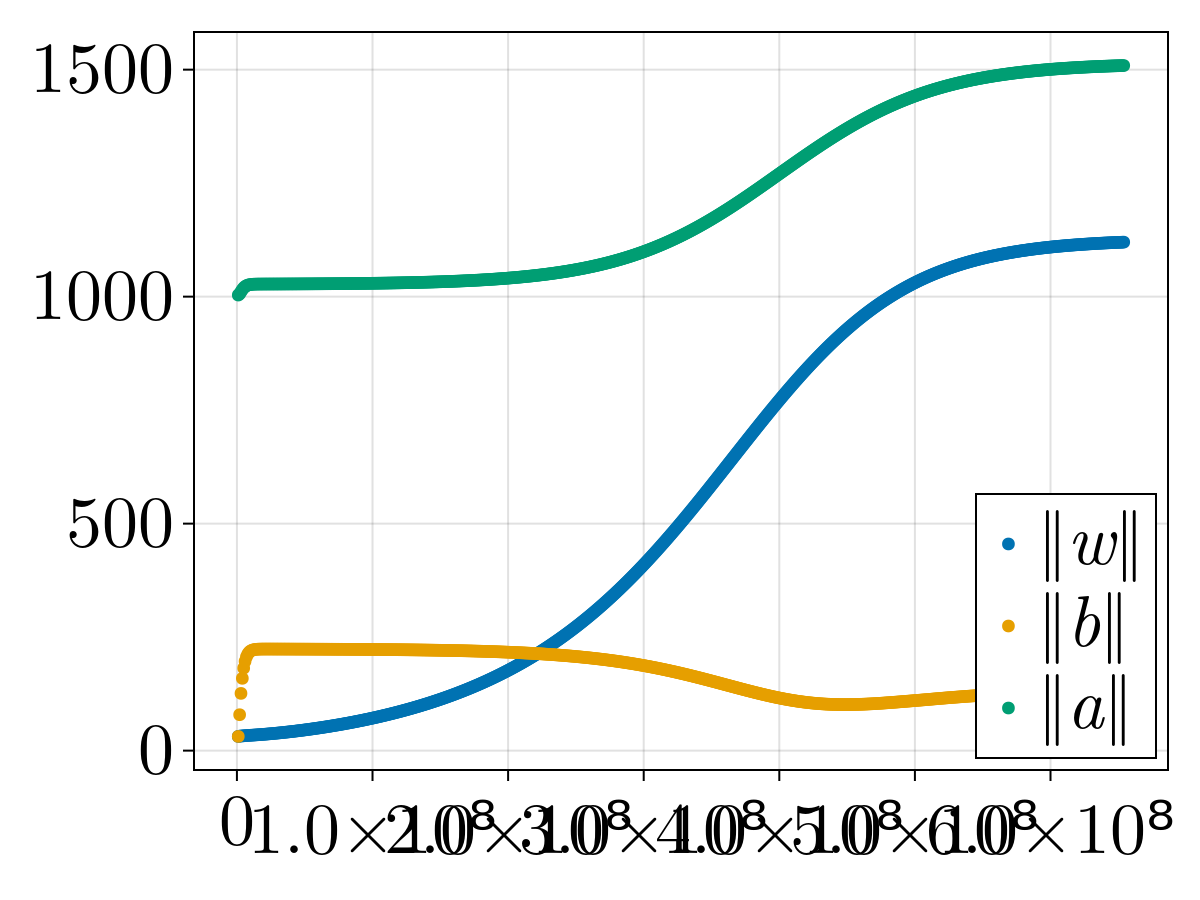

In [18]:
f = Figure()
ax = Axis(f[1, 1])

steps = 1000 * (1:length(w_norms)) * learning_rate

w_lines = scatter!(ax, steps, w_norms)
b_lines = scatter!(ax, steps, b_norms)
a_lines = scatter!(ax, steps, a_norms)

axislegend(ax, [w_lines, b_lines, a_lines], [L"\Vert w\Vert", L"\Vert b\Vert", L"\Vert a\Vert"], position=:rb)

f

In [7]:
f = Figure()
ax = Axis(f[1, 1], xscale = log10)

Axis with 0 plots:


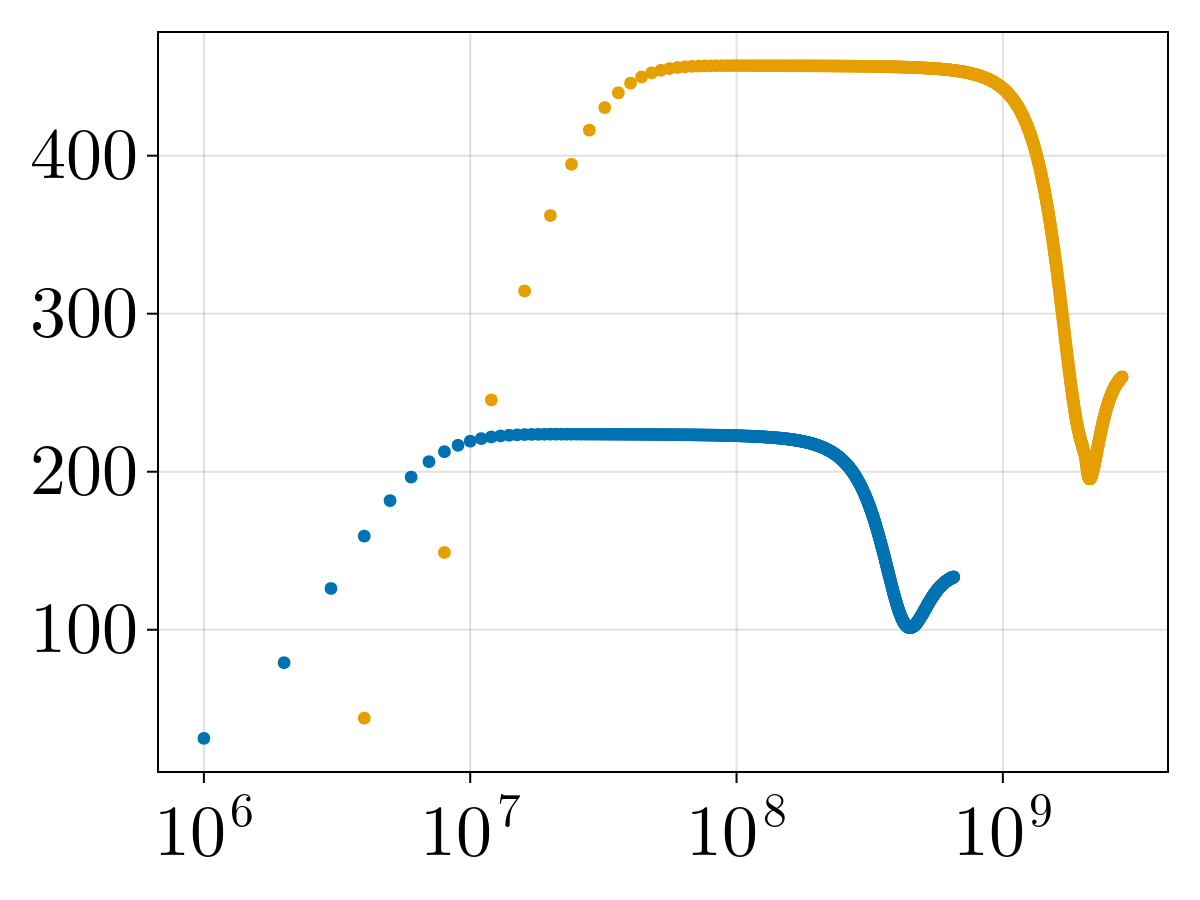

In [13]:
steps = 1000 * (1:length(w_norms)) * learning_rate
b_lines = scatter!(ax, steps, b_norms)

f

1.4e9


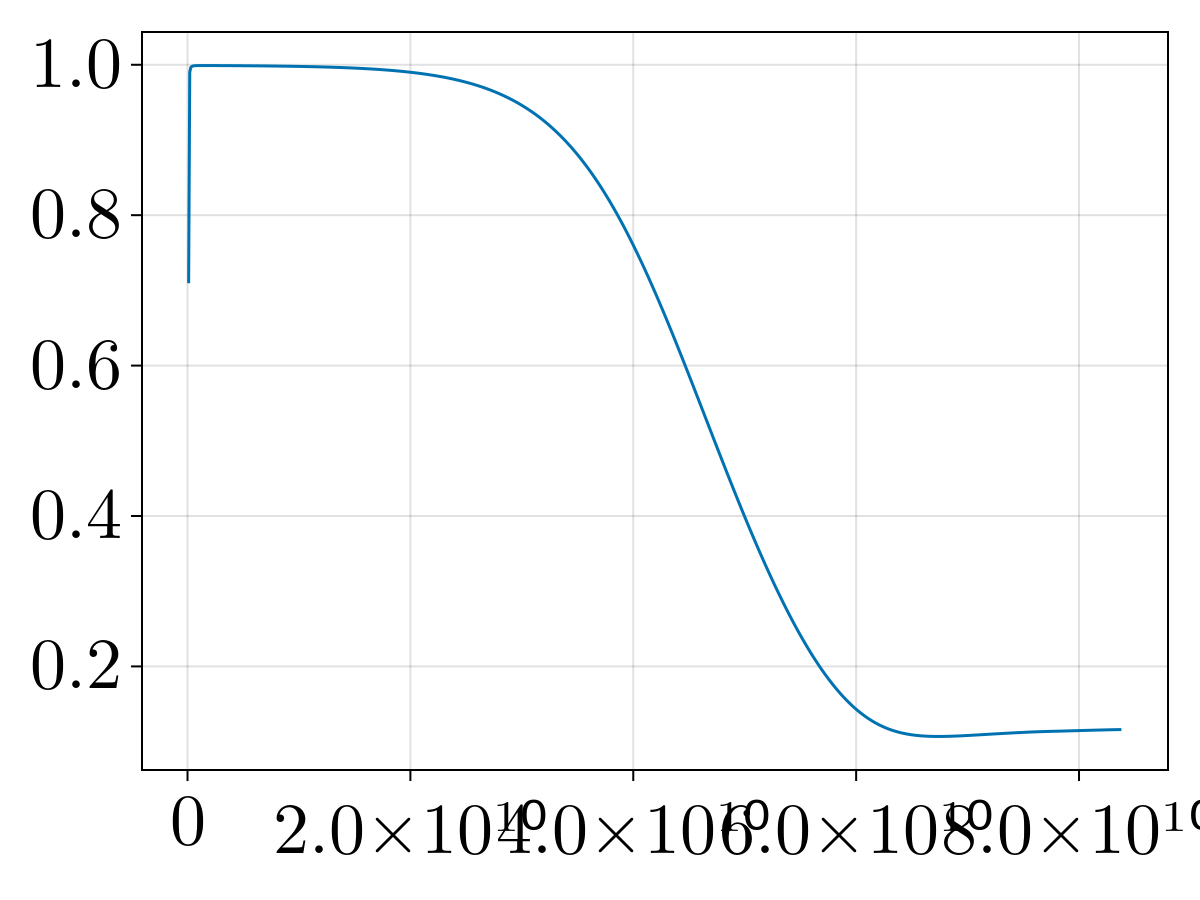

In [16]:
f = Figure()
ax = Axis(f[1, 1])

steps = 1000 * (1:length(w_norms)) * learning_rate

w_lines = lines!(ax, steps, b_norms ./ sqrt.(w_norms.^2 + b_norms.^2))

steps[argmax(b_norms ./ sqrt.(w_norms.^2 + b_norms.^2))] |> println

f

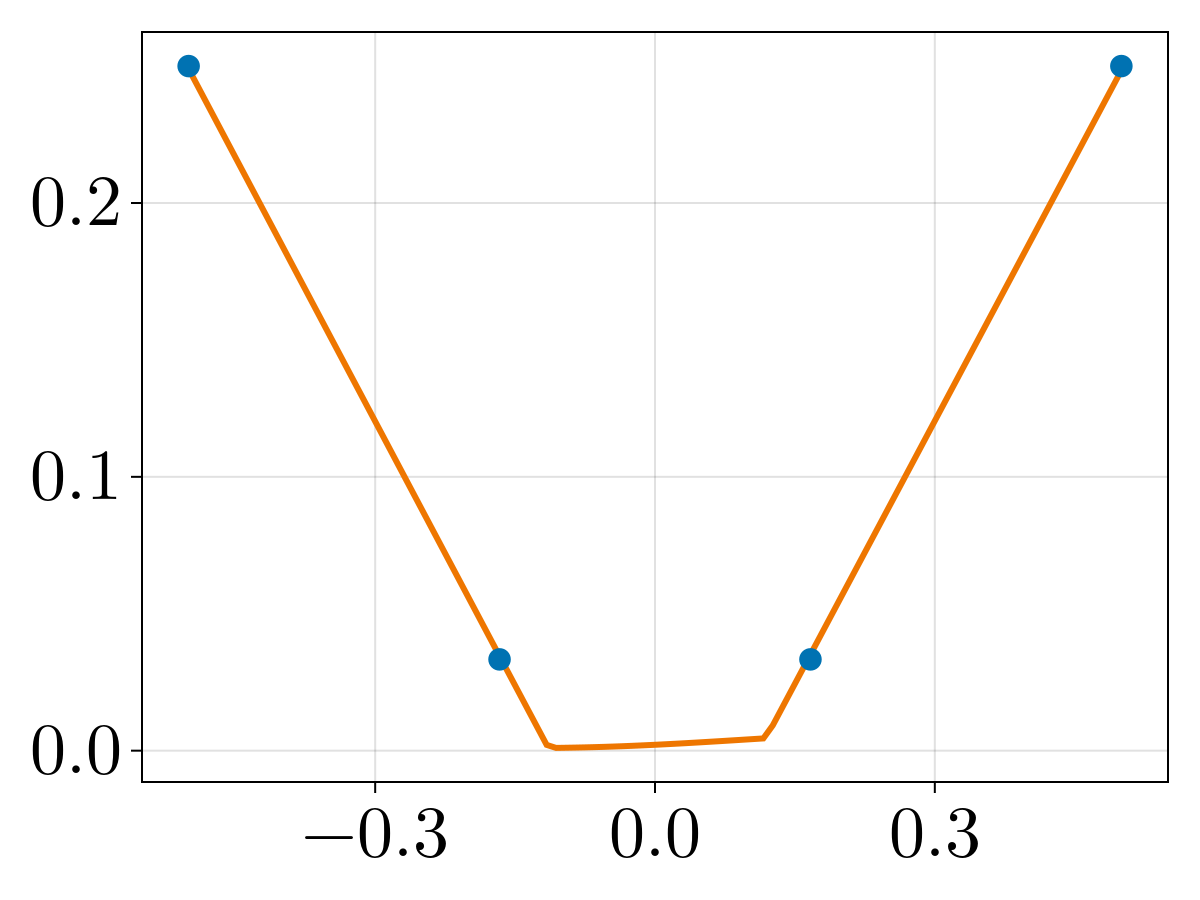

In [11]:
f = Figure()
ax = Axis(f[1, 1])

createlineplot!(ax, nn, training_data)

f

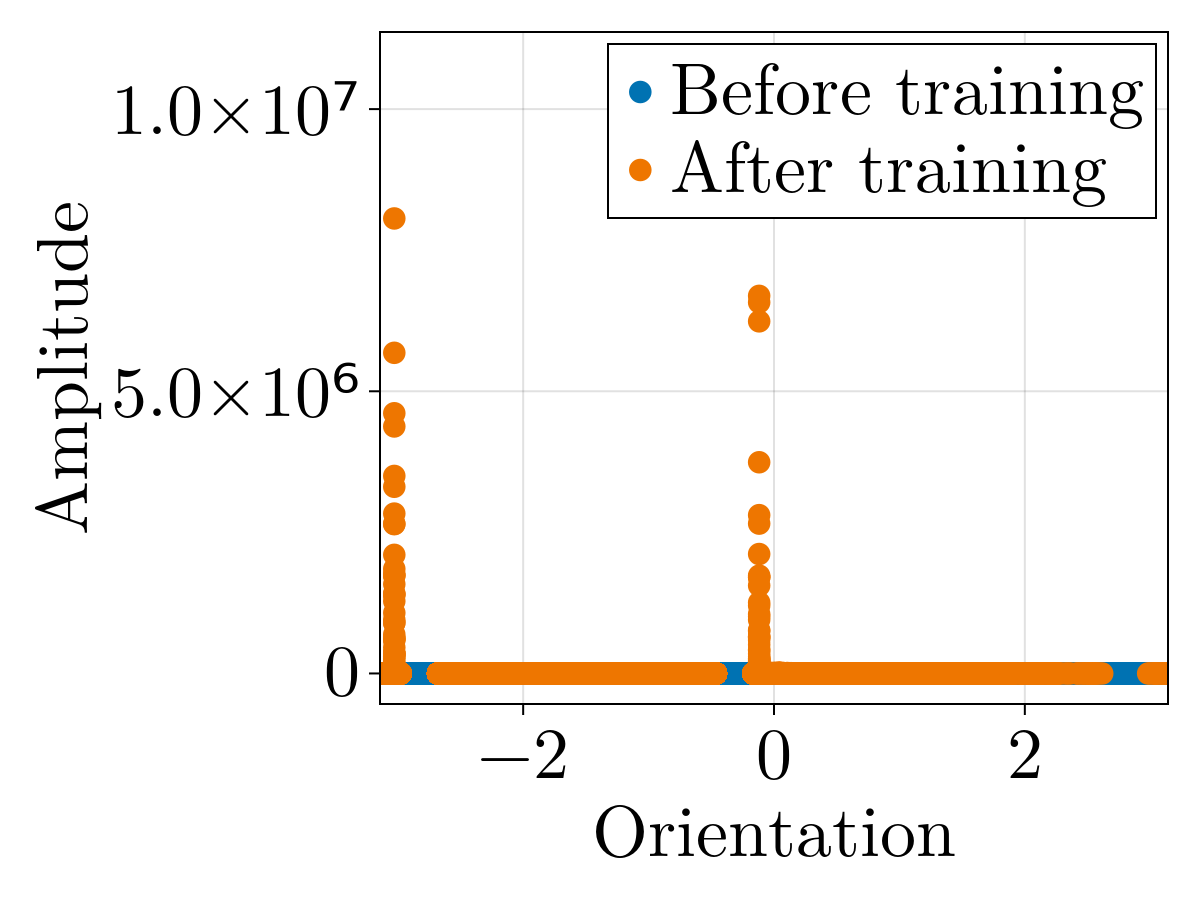

In [15]:
f = Figure()
ax = Axis(f[1, 1])

ylims!(ax, 0, 100)

createorientiationplot!(ax, initialNN, nn)

f

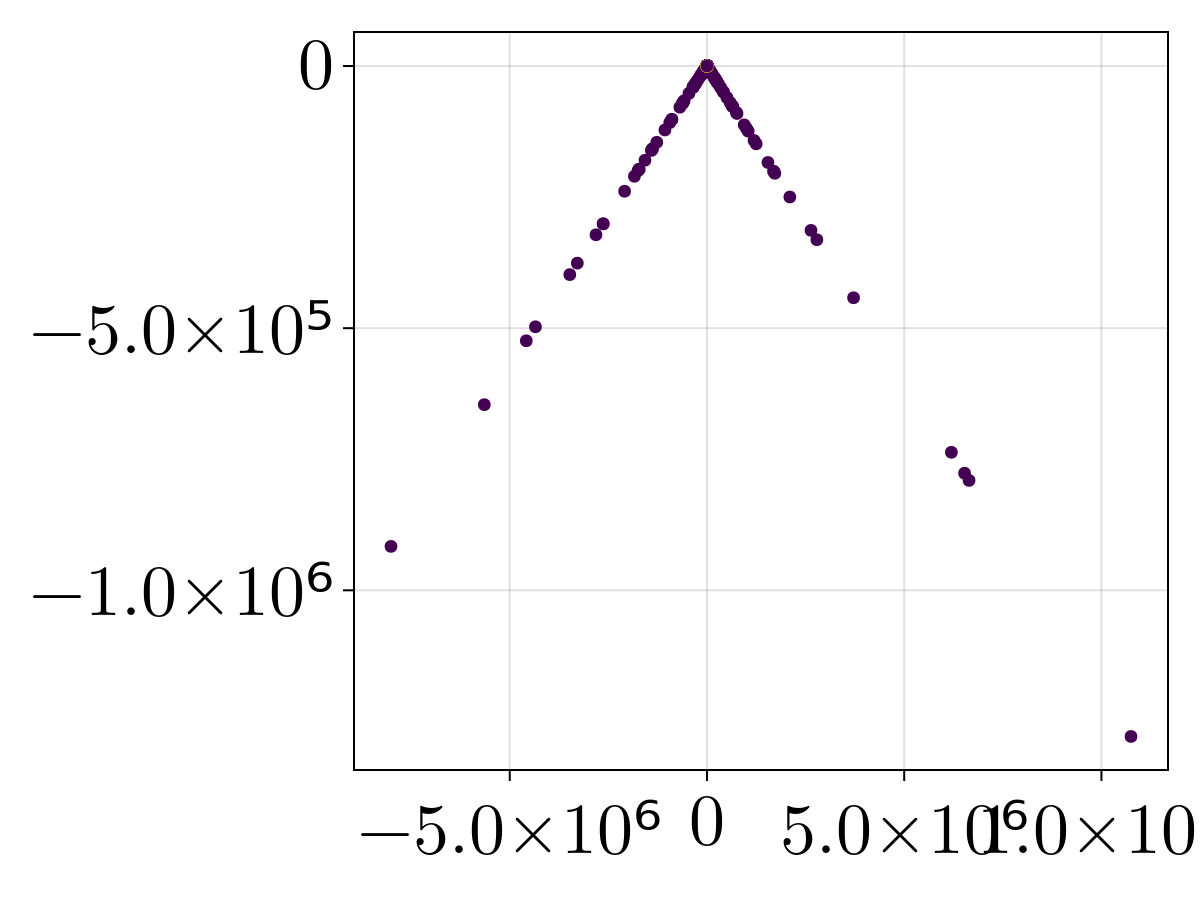

In [13]:
w_with_a = abs.(nn.a) .* vec(nn.w)
b_with_a = abs.(nn.a) .* nn.b
outputsigns = nn.a .|> signbit

scatter(w_with_a, b_with_a, color=outputsigns)

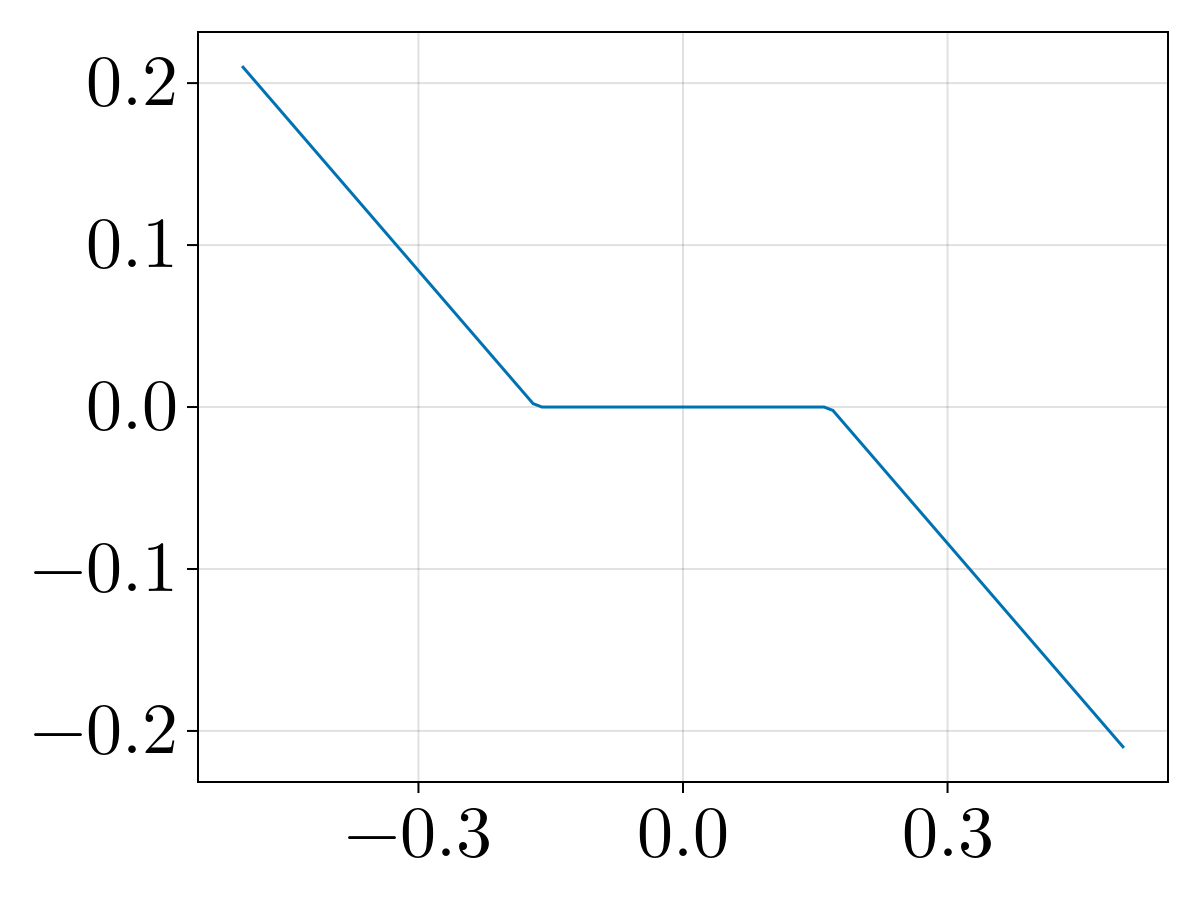

In [84]:
neuron_sizes = abs.(nn.a) .* vec(nn.w)

new_pos_neurons_idxs = partialsortperm(neuron_sizes, 1:3, rev=true)
new_neg_neurons_idxs = partialsortperm(neuron_sizes, 1:4)

new_neurons_idxs = vcat(new_pos_neurons_idxs, new_neg_neurons_idxs)

new_nn = x -> nn.a[new_neurons_idxs]' * MyTwoLayerNN.ReLu.σ.(nn.w[new_neurons_idxs] .* x + nn.b[new_neurons_idxs]) ./ nn.α


lines(-0.5:0.01:0.5, new_nn.(-0.5:0.01:0.5))

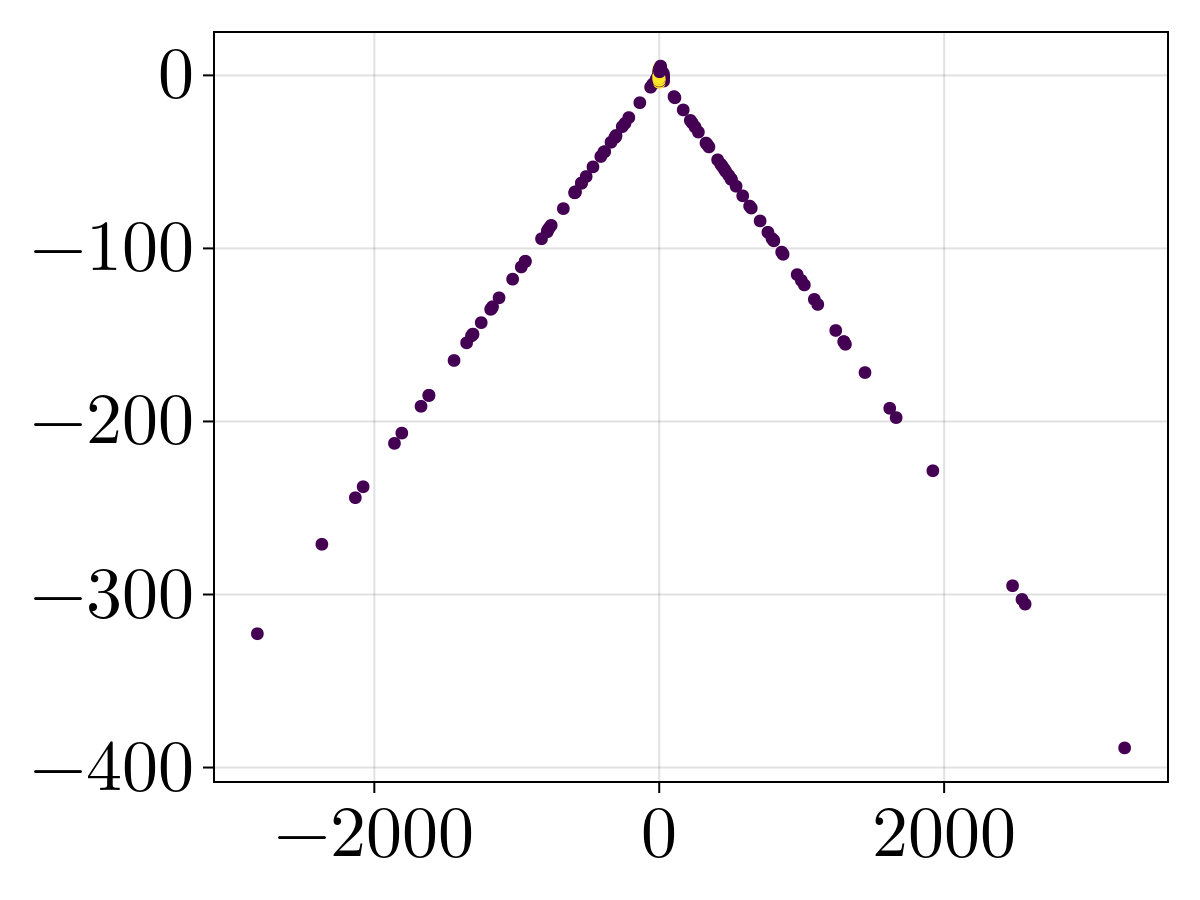

In [14]:
w_with_a = vec(nn.w)
b_with_a = nn.b
outputsigns = nn.a .|> signbit

f, ax, scat = scatter(w_with_a, b_with_a, color=outputsigns)

## Making movie

### Scatter plot of (w, b) over time

In [3]:
function my_movie(; nn::TwoLayerNN, learning_rate, 
                    xlim = nothing, ylim = nothing, total_epochs = 100_000, 
                    epochs_between_frames = 1000, framerate = 10, file_name="vid.mp4"
                )
    wobs = Observable(zero(abs.(nn.a) .* vec(nn.w)))
    bobs = Observable(zero(abs.(nn.a) .* nn.b))
    cobs = Observable(signbit.(nn.a))
    time = Observable(0.0)

    # Create initial plot
    fig, ax, scat = scatter(wobs, bobs, color = cobs, axis = (title = @lift("t = $(round($time, digits=1))"),))

    # Set axis limits
    !isnothing(xlim) && xlims!(ax, xlim...)
    !isnothing(ylim) && ylims!(ax, ylim...)

    # Movie parameters
    timestamps = range(0, total_epochs / (epochs_between_frames * framerate), step=1/framerate)

    # Training data
    training_data = TrainingData(dataX, dataY, learning_rate, epochs_between_frames)

    # Create video
    record(fig, file_name, timestamps; framerate = framerate) do t
        # Train NN from t > 0
        !iszero(t) && train!(nn, training_data; stop_tol = false)

        # Update scatter plot data
        wobs[] = abs.(nn.a) .* vec(nn.w)
        bobs[] = abs.(nn.a) .* nn.b
        cobs[] = signbit.(nn.a)
        time[] = t * framerate * epochs_between_frames * learning_rate
    end
end

my_movie (generic function with 1 method)

In [36]:
# boundary a- and w-lag
my_movie(
    nn = TwoLayerNN(d, 1000, 1.75, 0.0),
    learning_rate = 1000.0,
    xlim = (-21_000, 21_000), # wide: (-21_000, 21_000), mid: (-200, 200), close: (-5, 5), tiny: (-1, 1)
    ylim = (-3600, 1000), # wide: (-3600, 1000), mid: (ax, -100, 600), close: (-8, 20), tiny: (-2, 2)
    total_epochs = 130_000, # beginning: 16_000
    epochs_between_frames = 1000, # beginning: 80
    framerate = 10,
    file_name = "test.mp4"
)

Number of steps: 444


"test.mp4"

In [4]:
# w-lag regime
my_movie(
    nn = TwoLayerNN(d, 1000, 1.5, 0.25),
    learning_rate = 10.0,
    xlim = (-149, 149),
    ylim = (-24, 14),
    total_epochs = 270_000,
    epochs_between_frames = 1000,
    framerate = 10,
    file_name = "w-lag wide.mp4"
)

"a-lag wide.mp4"

In [14]:
# a-lag regime
my_movie(
    nn = TwoLayerNN(d, 1000, 1.5, -0.5),
    learning_rate = 1000.0,
    xlim = (-490_000, 490_000),
    ylim = (-60_000, 10_000),
    total_epochs = 653_000,
    epochs_between_frames = 1000,
    framerate = 10,
    file_name = "a-lag wide.mp4"
)

"a-lag wide.mp4"

### Multiple plots over time

In [86]:
# Makie.RGB(213/255, 94/255, 0/255) # Nice orange
theme_2plot_vid = merge(theme_latexfonts(),
    Theme(
        fontsize = 36,
        Lines = (
            color = Makie.RGB(213/255, 94/255, 0/255),
            cycle = [],
            linewidth = 3,
        ),
        Scatter = (
            markersize = 16,
        )
    )
);

In [87]:
function movie_multiple_plots(; nn::TwoLayerNN, learning_rate, 
                                xlim = nothing, ylim = nothing, total_epochs = 100_000, 
                                epochs_between_frames = 1000, framerate = 10, file_name="vid.mp4"
                            )
    with_theme(theme_2plot_vid) do # Start theme
    
    # Determine minimum and maximum x-values
    xmin, xmax = dataX |> Iterators.flatten |> extrema
    xvals = range(xmin, xmax, length=100)
    
    # Scatter plot observables 
    wobs = Observable(zero(abs.(nn.a) .* vec(nn.w)))
    bobs = Observable(zero(abs.(nn.a) .* nn.b))
    cobs = Observable(signbit.(nn.a))
    
    # Line plot observables
    yobs = Observable([forward(nn, p) for p in xvals])
    iobs = Observable(-nn.b ./ vec(nn.w))
    iyobs = Observable([forward(nn, p) for p in iobs[]])
    
    # General observables
    time = Observable(0.0)
    
    # Create initial scatter plot
    fig, ax, scat = scatter(wobs, bobs, color = cobs, figure=(size=(1500, 750),))
        
    # Set axis limits
    !isnothing(xlim) && xlims!(ax, xlim...)
    !isnothing(ylim) && ylims!(ax, ylim...)
    
    # Create initial line plot
    ax2 = Axis(fig[1, 2])
    lines!(ax2, xvals, yobs)
    scatter!(ax2, vcat(dataX...), dataY)
    scatter!(ax2, iobs, iyobs, marker=:star5, color=:darkgreen)
    xlims!(ax2, -0.55, 0.55)
    
    # Create figure title
    Label(fig[0, :], @lift("t = $(round($time, digits=1))"), fontsize = 40)

    # Movie parameters
    timestamps = range(0, total_epochs / (epochs_between_frames * framerate), step=1/framerate)
    
    # Training data 
    training_data = TrainingData(dataX, dataY, learning_rate, epochs_between_frames)
    
    # Create video
    record(fig, file_name, timestamps; framerate = framerate) do t
        # Train NN from t > 0
        !iszero(t) && train!(nn, training_data; stop_tol = false)
    
        # Update scatter plot data
        wobs[] = abs.(nn.a) .* vec(nn.w)
        bobs[] = abs.(nn.a) .* nn.b
        cobs[] = signbit.(nn.a)
    
        # Update line plot data
        yobs[] = [forward(nn, p) for p in xvals]
        iobs[] = -nn.b ./ vec(nn.w)
        iyobs[] = [forward(nn, p) for p in iobs[]]
    
        # Update title
        time[] = t * framerate * epochs_between_frames * learning_rate
    end
    end # end theme
end

movie_multiple_plots (generic function with 1 method)

In [70]:
# boundary a- and w-lag
movie_multiple_plots(
    nn = TwoLayerNN(d, 1000, 1.75, 0.0),
    learning_rate = 1000.0,
    xlim = (-21_000, 21_000),
    ylim = (-3600, 1000),
    total_epochs = 130_000,
    epochs_between_frames = 1000,
    framerate = 10,
    file_name = "crit wide double.mp4"
)

"crit wide double.mp4"

In [71]:
# w-lag regime
movie_multiple_plots(
    nn = TwoLayerNN(d, 1000, 1.5, 0.25),
    learning_rate = 10.0,
    xlim = (-149, 149),
    ylim = (-24, 14),
    total_epochs = 270_000,
    epochs_between_frames = 1000,
    framerate = 10,
    file_name = "w-lag wide double.mp4"
)

"w-lag wide double.mp4"

In [90]:
# a-lag regime
movie_multiple_plots(
    nn = TwoLayerNN(d, 1000, 1.5, -0.5),
    learning_rate = 1000.0,
    xlim = (-1000, 1000), # Wide: (-490_000, 490_000), close: (-1000, 1000)
    ylim = (-250, 4000), # Wide: (-59_000, 10_000), close: (-250, 4000)
    total_epochs = 40_000, # Long: 653_000
    epochs_between_frames = 100, # Long: 1000
    framerate = 10,
    file_name = "test a-lag mid begin double.mp4"
)

"test a-lag mid begin double.mp4"

In [32]:
# Asymetric data
movie_multiple_plots(
    nn = TwoLayerNN(d, 1000, 1.75, 0.0),
    learning_rate = 1000.0,
    xlim = (-1, 1), # Wide: (-80_000, 80_000), Mid: (-1200, 1200), Close: (-20, 20)
    ylim = (-1, 1), # Wide: (-14_000, 1_000), Mid: (-200, 1100), Close: (-10, 10)
    total_epochs = 25_000, # Long: 889_000
    epochs_between_frames = 1000, # Long: 1000
    framerate = 10,
    file_name = "asymetric tiny double.mp4"
)

"asymetric tiny double.mp4"

## Report pictures

In [ ]:
theme_test = merge(theme_latexfonts(),
    Theme(
        fontsize = 30,
        Axis = (
            xticklabelsize = 25, 
            yticklabelsize = 25,
        ),
        Lines = (
            color = Makie.RGB(213/255, 94/255, 0/255),
            cycle = [],
            linewidth = 3,
        ),
        Scatter = (
            markersize = 16,
        )
    )
);

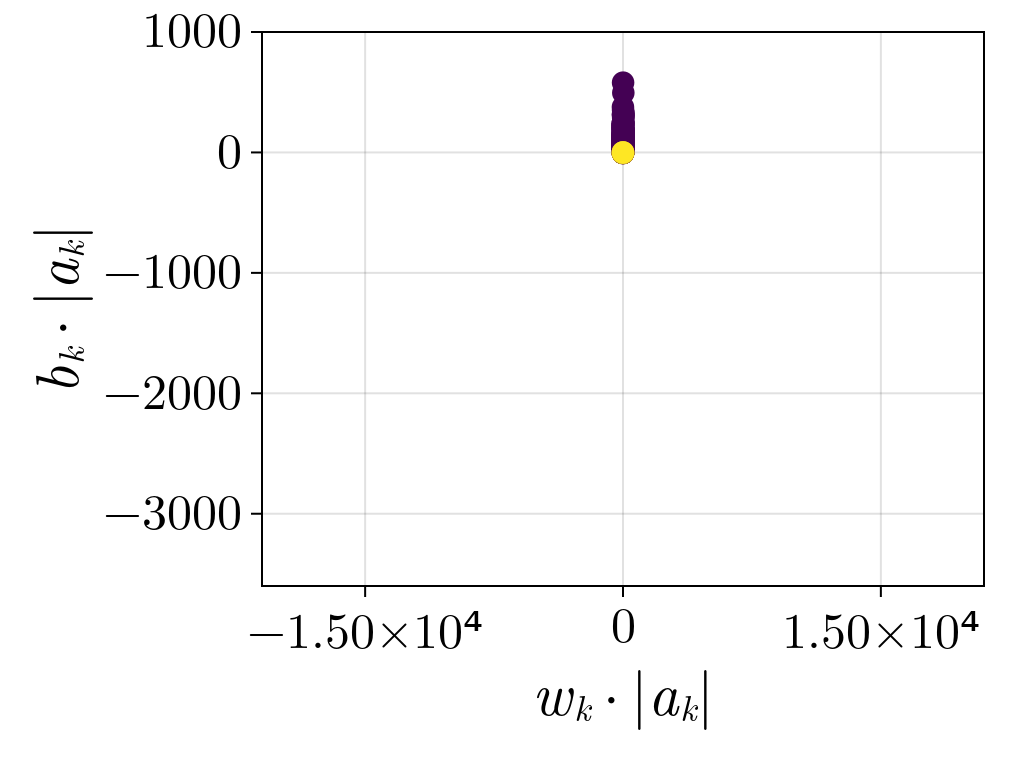

In [162]:
with_theme(theme_test) do
w_with_a = abs.(nn.a) .* vec(nn.w)
b_with_a = abs.(nn.a) .* nn.b
outputsigns = nn.a .|> signbit

f = Figure(size = (480, 380))
ax = Axis(f[1, 1], xticks = [-15_000, 0, 15_000], xlabel = L"w_k \cdot |a_k|", ylabel=L"b_k \cdot |a_k|")
xlims!(ax, -21_000, 21_000)
ylims!(ax, -3600, 1000)

scatter!(ax, w_with_a, b_with_a, color=outputsigns, markersize=16)

colsize!(f.layout, 1, Aspect(1, 1.3))
resize_to_layout!(f)

save("mid training.pdf", f)
f
end

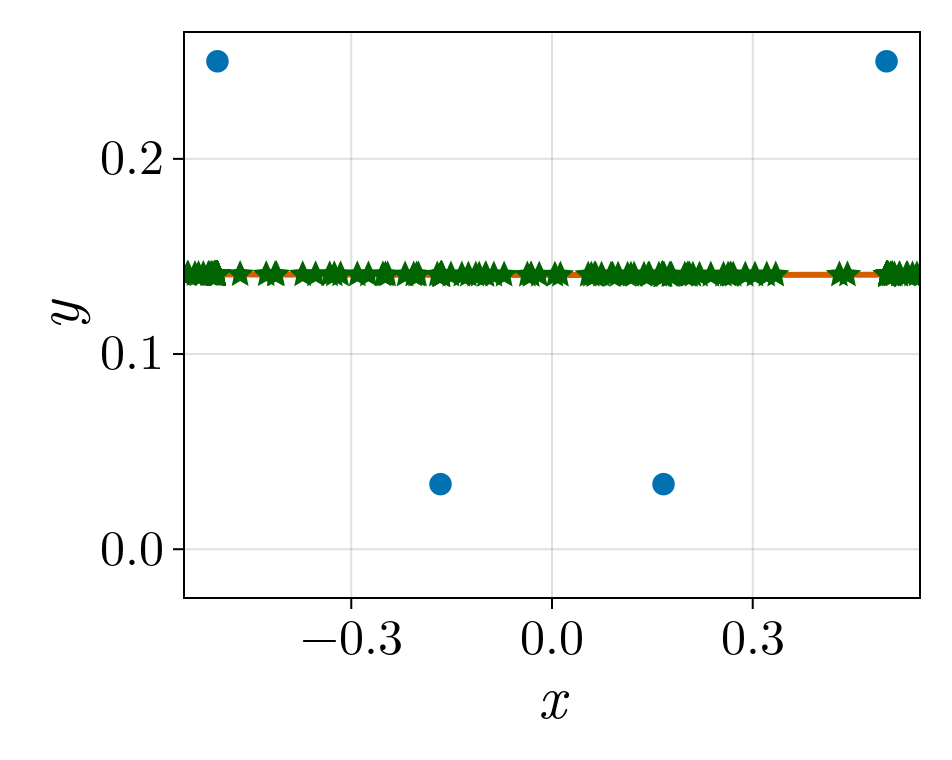

In [161]:
with_theme(theme_test) do
    f = Figure(size = (480, 380))
    ax = Axis(f[1, 1], xlabel=L"x", ylabel=L"y")

    xmin, xmax = dataX |> Iterators.flatten |> extrema
    xvals = range(xmin, xmax, length=100)

    lines!(ax, xvals, [forward(nn, p) for p in xvals])
    scatter!(ax, vcat(dataX...), dataY)

    inflection_points = -nn.b ./ vec(nn.w)
    scatter!(ax, inflection_points, [forward(nn, p) for p in inflection_points], marker=:star5, color=:darkgreen)
    xlims!(ax, -0.55, 0.55)
    ylims!(ax, -0.025, 0.265)

    colsize!(f.layout, 1, Aspect(1, 1.3))
    resize_to_layout!(f)

    save("mid line training.pdf", f, pt_per_unit = 1/3)
    f
end

## Orientation over time

In [86]:
# Data parameters
d = 1
dataX = [[-1/2], [-1/6], [1/6], [1/2]]
dataY = [1/4, 1/30, 1/30, 1/4]

# NN parameters
m = 1_000
γ = 1.75
γ′ = 0.0

nn = TwoLayerNN(d, m, γ, γ′)

# Create copy of inital weights 
initialNN = copy(nn)

# Training parameters
learning_rate = 1000.0
max_steps = 100_000_000

training_data = TrainingData(dataX, dataY, learning_rate, max_steps)

TrainingData{Float64, Int64}([[-0.5], [-0.16666666666666666], [0.16666666666666666], [0.5]], [0.25, 0.03333333333333333, 0.03333333333333333, 0.25], 1000.0, 100000000)

In [87]:
orientations = angle.(vec(nn.w) + im * nn.b)

function callback_ovt(nn, step, loss)
    if step % 1000 == 1
        global orientations=cat(orientations, angle.(vec(nn.w) + im * nn.b); dims=2)
    end
end

callback_ovt (generic function with 1 method)

In [88]:
train!(nn, training_data; callback=callback_ovt)

Number of steps: 129444


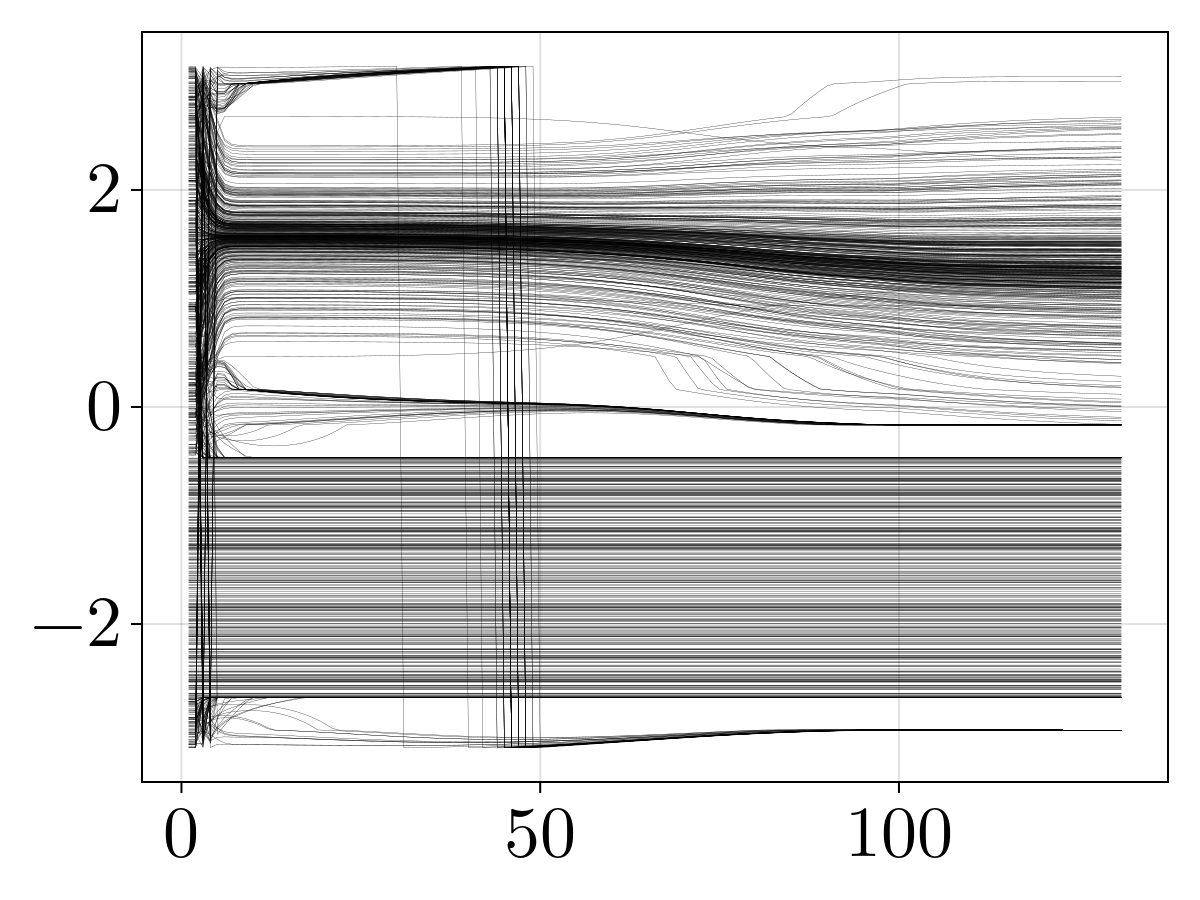

In [90]:
series(orientations; solid_color=:black, linewidth=0.15)

## b over time

In [3]:
# Data parameters
d = 1
dataX = [[-1/2], [-1/6], [1/6], [1/2]]
dataY = [1/4, 1/30, 1/30, 1/4]

# NN parameters
γ = 1.5    # w-lag (1.5, 0.25) lr=10, a-lag (1.5, -0.5) lr=1000
γ′ = -0.5

# Training parameters
max_steps = 100_000_000

100000000

In [4]:
function callbackgenerator(my_array) 
    last_T_score = 0.0
    return (nn, step, loss; ∇=nothing) -> begin
        bnorm = norm(nn.b)
    
        # Check whether to stop
        temp_T_score = bnorm / sqrt(norm(nn.w)^2 + bnorm^2) 
        last_T_score > temp_T_score && step > 1000 && return true
        last_T_score = temp_T_score

        # Push new bnorm
        push!(my_array, bnorm)
    end
end

callbackgenerator (generic function with 1 method)

In [19]:
b_norms_data::Vector{Tuple{Int64, Float64, Vector{Float64}}} = []

for (m, η) ∈ [(1000, 1e3), (10_000, 1e6), (100_000, 1e9)] #[(1000, 1000.0), (2000, 4000.0), (3000, 9000.0), (4000, 16_000.0)]
    nn = TwoLayerNN(d, m, γ, γ′)
    training_data = TrainingData(dataX, dataY, η, max_steps)

    b_norms_i = [norm(nn.b)]

    train!(nn, training_data; callback2=callbackgenerator(b_norms_i))

    push!(b_norms_data, (m , η, b_norms_i))
end

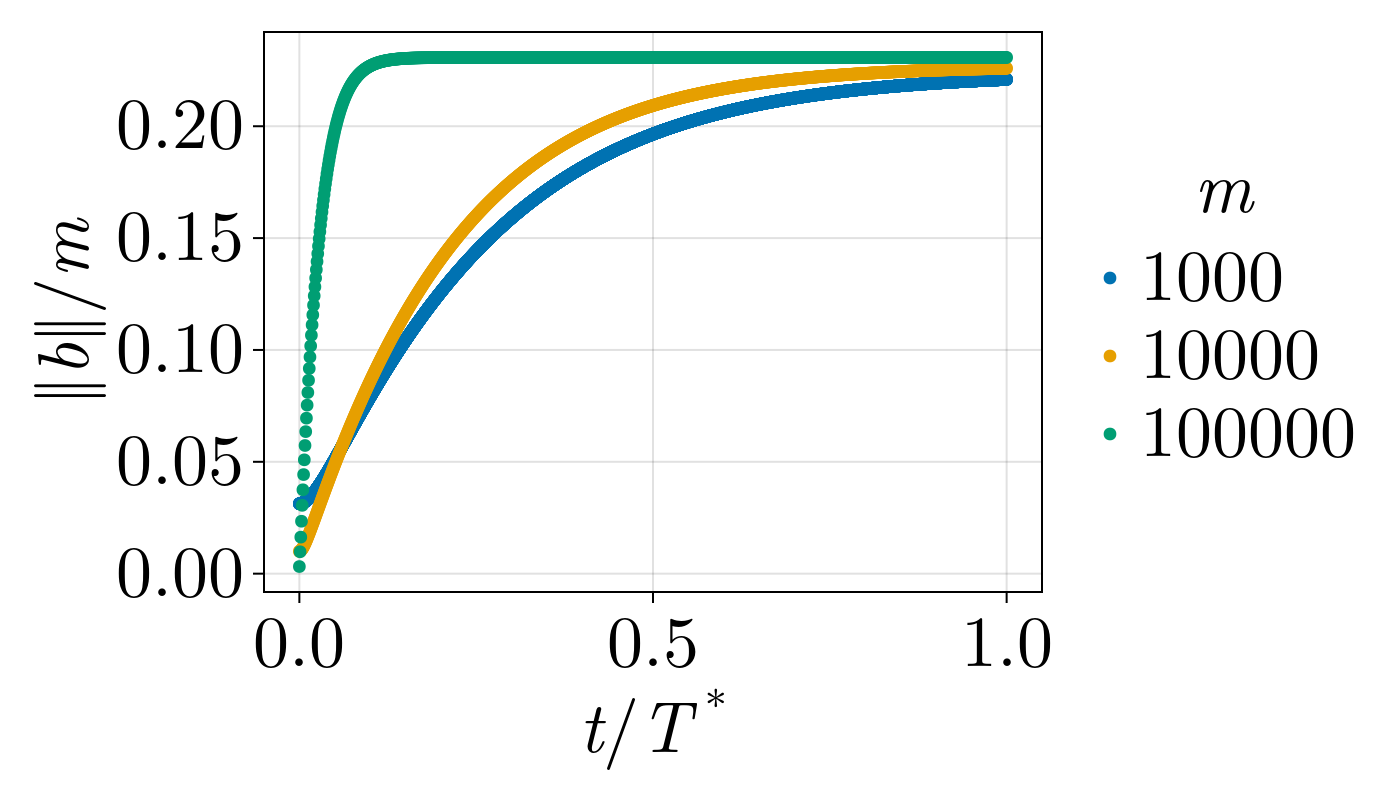

In [20]:
f = Figure(size=(700, 400))
ax = Axis(f[1, 1], xlabel=L"t/T^*", ylabel=L" \Vert b\Vert / m")

for (m, η, b_norms_i) ∈ b_norms_data
    scatter!(ax, range(0, 1, length=length(b_norms_i)), b_norms_i ./ m, label = L"%$(m)")
    # scatter!(ax, reverse(1 .- (0:1:(length(b_norms_i) - 1) .|> (x -> (exp(x / 500) - 1) / (exp((length(b_norms_i) - 1) / 500) - 1)))), b_norms_i ./ m)
end

Legend(f[1, 2], ax, L"m", framevisible = false)

f

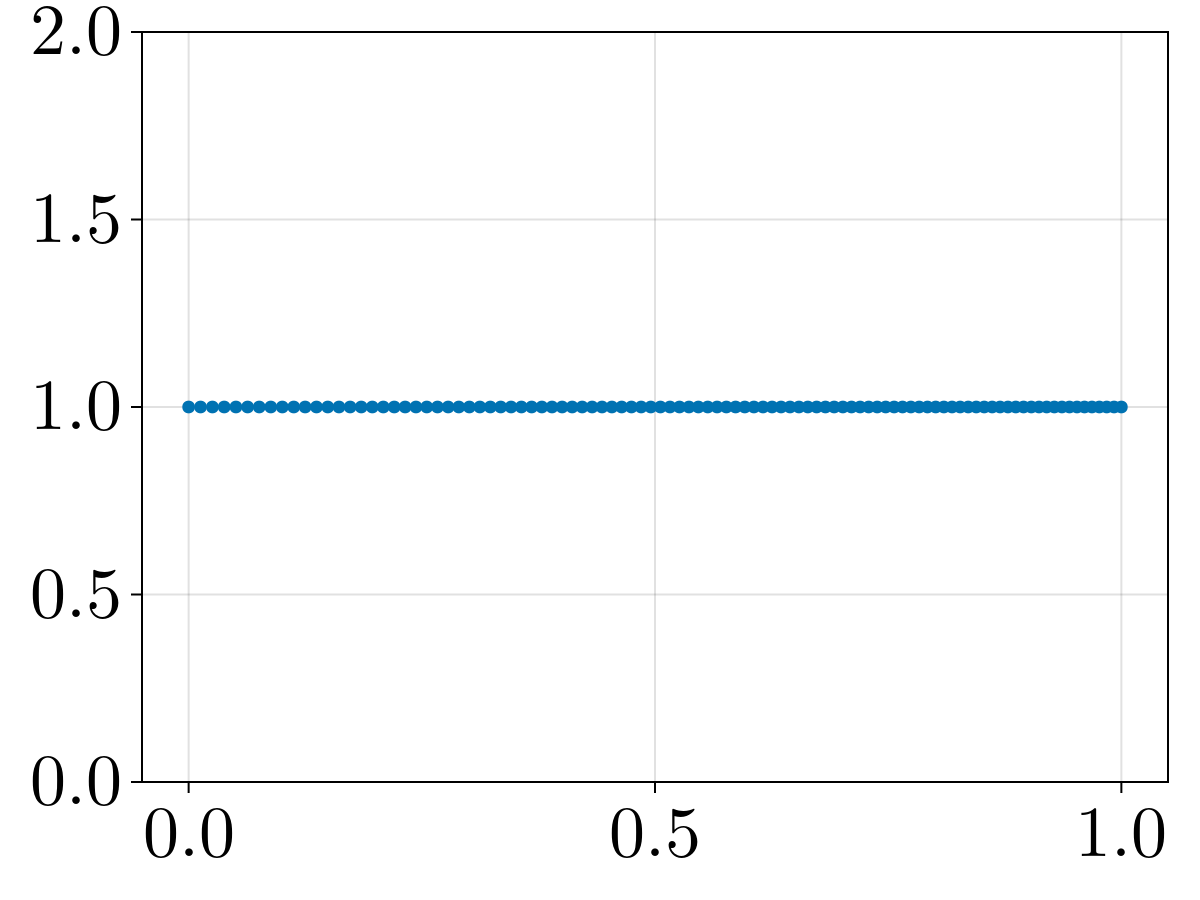

In [127]:
TEST_N = 100
TEST_C = 200
# scatter((0:1:(TEST_N - 1) .|> (x -> (exp(x / TEST_C) - 1) / (exp((TEST_N - 1) / TEST_C) - 1))), ones(TEST_N))
scatter(reverse(1 .- (0:1:(TEST_N - 1) .|> (x -> (exp(x / TEST_C) - 1) / (exp((TEST_N - 1) / TEST_C) - 1)))), ones(TEST_N))

In [18]:
b_norms_data[1][3] |> length |> println
b_norms_data[2][3] |> length |> println
b_norms_data[3][3] |> length |> println
b_norms_data[4][3] |> length |> println

9979
1259
1001
1001
